In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel

from scipy.stats import pearsonr

from langdetect import detect
import langid

pd.set_option('display.max_colwidth', 50)

In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

Real News Dataset

In [19]:
# Load data from CSV file
df_real = pd.read_csv('Final_real_dataset.csv')
df_real.head()

,Text,Source,URL
0,“O SNS tem hoje cerca de 4300 médicos especial...,"Manuel Pizarro, ministro da Saúde",https://www.publico.pt/2022/12/09/sociedade/no...
1,"""Não tinha de me pronunciar nem ter conhecimen...","Marcelo Rebelo de Sousa, Presidente da República",https://www.publico.pt/2023/03/03/politica/not...
2,"“Nós temos, em Portugal, quase um milhão de pe...","Luís Montenegro, presidente do PSD",https://www.publico.pt/2022/08/19/politica/not...
3,Já defendo o referendo sobre a eutanásia há qu...,"Luís Montenegro, presidente do PSD",https://www.publico.pt/2022/12/06/politica/not...
4,“Tenho uma regra de não comentar no exterior a...,"António Costa, primeiro-ministro",https://www.publico.pt/2022/06/30/politica/not...


In [20]:
check(df_real)

,column,dtypes,nunique,sum_null
0,Text,object,31664,1
1,Source,object,226,960
2,URL,object,31717,0


In [21]:
#df.drop(columns=['Unnamed: 0'],inplace=True)

In [22]:
# delete missing data
#df.dropna(inplace=True)
df_real.dropna(subset=['Text'], inplace=True)

In [29]:
# check for duplicate rows
df_real.duplicated().sum()

4

In [30]:
# delete duplicate rows
df_real.drop_duplicates(inplace=True)

In [31]:
check(df_real)

,column,dtypes,nunique,sum_null
0,Text,object,31664,0
1,Source,object,225,960
2,URL,object,31716,0


Fake News Dataset

In [24]:
# Load data from CSV file
df_fake = pd.read_csv('Final_fake_dataset.csv')
df_fake.head()

,Text,Source,URL
0,Filomena Cautela apanhada a conduzir com Alcoo...,NaN,https://www.direitapolitica.com/filomena-caute...
1,António Costa fará de tudo para se manter no p...,NaN,https://www.direitapolitica.com/antonio-costa-...
2,Os portugueses andam a ser enganados há muito ...,NaN,https://www.direitapolitica.com/os-portugueses...
3,Pablo Iglesias (extrema-esquerda espanhola) su...,NaN,https://www.direitapolitica.com/pablo-iglesias...
4,"Actor Jon Voight, pai de Angelina Jolie, arras...",NaN,https://www.direitapolitica.com/actor-jon-voig...


In [25]:
check(df_fake)

,column,dtypes,nunique,sum_null
0,Text,object,20619,23
1,Source,object,2908,12064
2,URL,object,31542,0


In [26]:
#df.drop(columns=['Unnamed: 0'],inplace=True)

In [27]:
# delete missing data
#df.dropna(inplace=True)
df_fake.dropna(subset=['Text'], inplace=True)

In [32]:
# check for duplicate rows
df_fake.duplicated().sum()

0

In [33]:
# delete duplicate rows
df_fake.drop_duplicates(inplace=True)

In [34]:
check(df_fake)

,column,dtypes,nunique,sum_null
0,Text,object,20619,0
1,Source,object,2906,12043
2,URL,object,31519,0


In [35]:
# Add a new "Label" column to each DataFrame
df_real['Label'] = 1
df_fake['Label'] = 0

# Concatenate the two DataFrames into a single DataFrame
final_df = pd.concat([df_real, df_fake], ignore_index=True)

# Shuffle the rows in the DataFrame (optional but recommended)
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [36]:
final_df.head()

,Text,Source,URL,Label
0,PJ em operação internacional de tráfico de dro...,DN,https://www.dn.pt/sociedade/pj-em-operacao-int...,1
1,O texto foi criado - numa universidade da Repú...,NaN,https://poligrafo.sapo.pt/fact-check/fact-chec...,1
2,Nunca pague multas por conduzir sem carta ou s...,Contas Poupança,https://arquivo.pt/wayback/20200626170105mp_/h...,0
3,"Depois de António Guterres, uma estátua de D. ...",redes sociais,https://poligrafo.sapo.pt/fact-check/fact-chec...,0
4,"O MAR, uma droga gratuita que cura pelo menos ...",Coruja,https://arquivo.pt/wayback/20181012145922mp_/h...,0


In [48]:
# check for duplicate rows
final_df.duplicated().sum()

0

In [49]:
check(final_df)

,column,dtypes,nunique,sum_null
0,Text,object,52283,0
1,Source,object,3101,13003
2,URL,object,63235,0
3,Label,int64,2,0


In [39]:
final_df.to_csv("Final_dataset_portuguese.csv", index = False)

1    31716
0    31520
Name: Label, dtype: int64


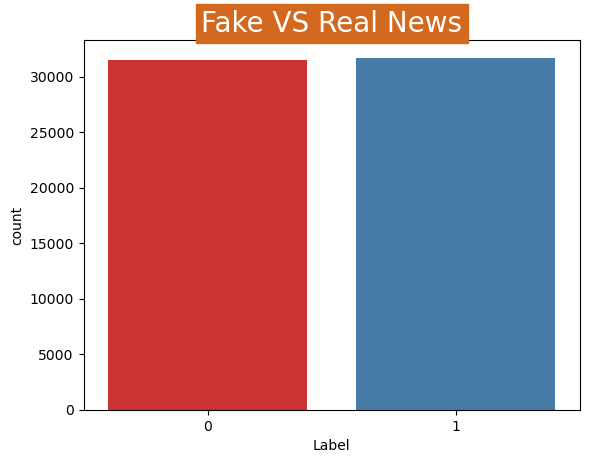

In [46]:
chart=sns.countplot(x='Label',data=final_df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='20',
          backgroundcolor='chocolate',
          color='white')

counts = final_df['Label'].value_counts()

print(counts)

In [11]:
df = pd.read_csv("Final_dataset_portuguese.csv")

In [4]:
check(df)

,column,dtypes,nunique,sum_null
0,Text,object,52283,0
1,Source,object,3101,13003
2,URL,object,63235,0
3,Label,int64,2,0


In [12]:
df.head()

,Text,Source,URL,Label
0,PJ em operação internacional de tráfico de dro...,DN,https://www.dn.pt/sociedade/pj-em-operacao-int...,1
1,O texto foi criado - numa universidade da Repú...,NaN,https://poligrafo.sapo.pt/fact-check/fact-chec...,1
2,Nunca pague multas por conduzir sem carta ou s...,Contas Poupança,https://arquivo.pt/wayback/20200626170105mp_/h...,0
3,"Depois de António Guterres, uma estátua de D. ...",redes sociais,https://poligrafo.sapo.pt/fact-check/fact-chec...,0
4,"O MAR, uma droga gratuita que cura pelo menos ...",Coruja,https://arquivo.pt/wayback/20181012145922mp_/h...,0


In [17]:
df['Text'] = df['Text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))
#df['Text'] = df['Text'].apply(lambda x: x.lower())

In [15]:
stop_words = set(stopwords.words('portuguese'))
#df['title'] = df['title'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
import collections

Text(0.5, 1.0, '15 Most Common Words in Real News')

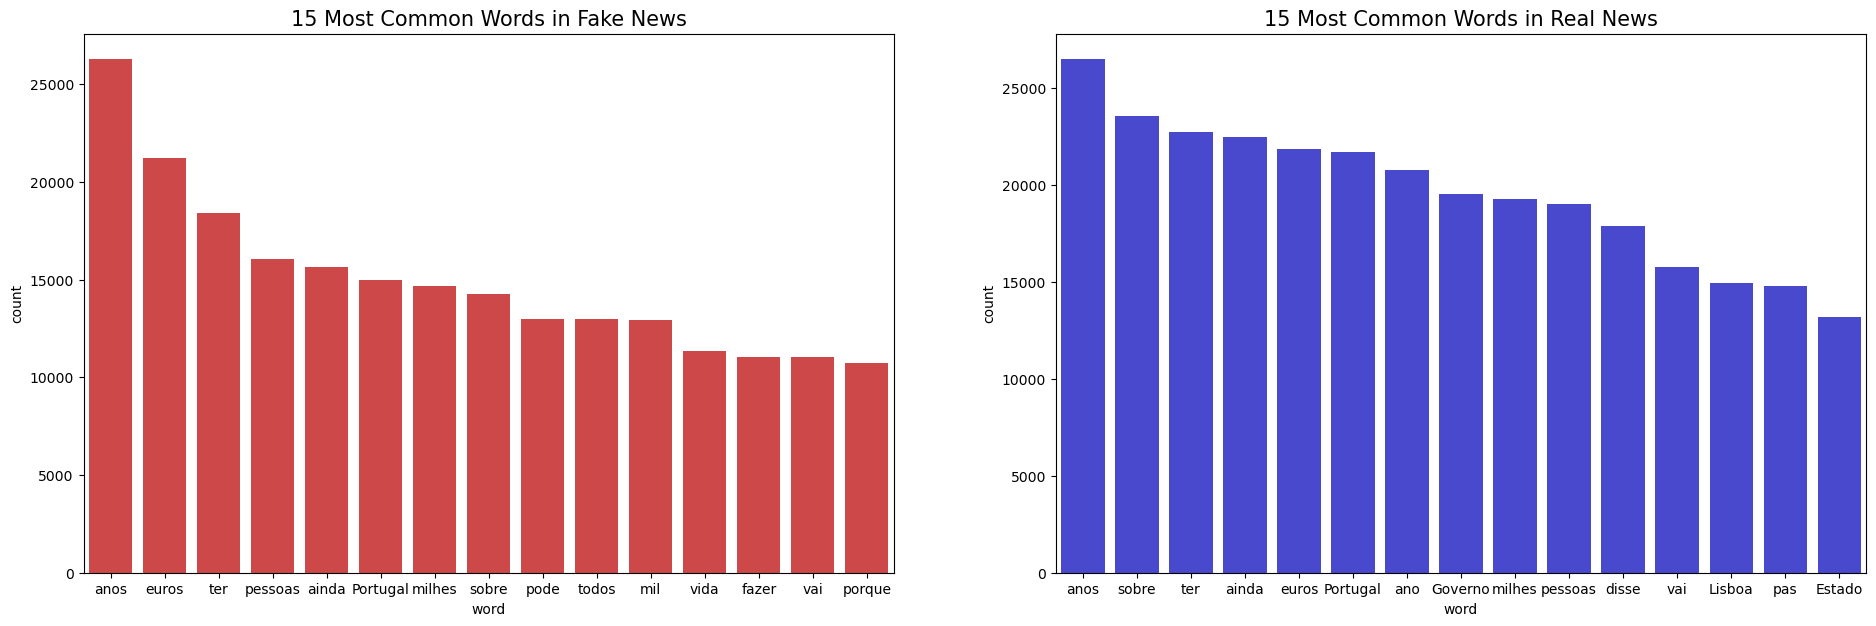

In [21]:
#get word collections for real/fake news
fake_news_words = collections.Counter([word for sentence in df.loc[df['Label'] == 0]['Text'] for word in sentence.split()])
real_news_words = collections.Counter([word for sentence in df.loc[df['Label'] == 1]['Text'] for word in sentence.split()])
df_mc_fake = pd.DataFrame(columns = ['word','count'], data=(fake_news_words.most_common(15)))
df_mc_real = pd.DataFrame(columns = ['word','count'], data=(real_news_words.most_common(15)))

fig, axes = plt.subplots(1,2,figsize = (23, 7))

sns.barplot(data = df_mc_fake, x= 'word', y = 'count', color = '#dd0000', alpha = 0.8, ax = axes[0])
axes[0].set_title('15 Most Common Words in Fake News',  fontsize=15)
sns.barplot(data = df_mc_real, x= 'word', y = 'count', color = '#0000dd', alpha = 0.8, ax = axes[1])
axes[1].set_title('15 Most Common Words in Real News',  fontsize=15)

In [2]:
df = pd.read_csv("Final_dataset_portuguese.csv")

1    31716
0    31520
Name: Label, dtype: int64


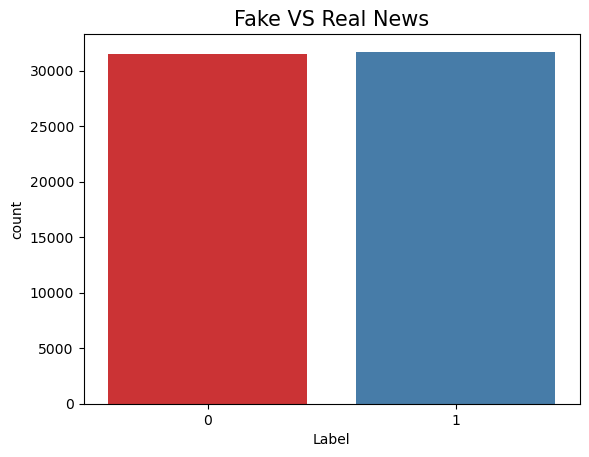

In [5]:
chart=sns.countplot(x='Label',data=df,palette='Set1')
plt.title("Fake VS Real News",
          fontsize='15',
          color='black')

counts = df['Label'].value_counts()

print(counts)